# Overview

I had previously developed surveys with multiple choice and open-ended questions and had collected data from students. For my 10 Days of Code Data Science bootcamp project, I decided to develop a workflow to explore some of the open-ended responses using Natural Language Processing. I played around with Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) to do some topic modeling on my dataset. Ultimately, I chose to use NMF because it plays better with smaller datasets. After the camp, I used Bokeh to do some visual exploration. I'm a coding newbie, so there are a lot of notes for beginners.

(At a very high level, the reason NMF works better than LDA: NMF does 1 level of fitting and LDA does 2 levels of fitting; to train the second level of fitting, you would need a lot more data.)

Caution: As you'll see below, I did not use all the words in my corpus. I removed stop words, did some stemming, etc. Be careful not to change the meaning of your original data when removing/altering words. My choices below may not be the best choices for another project. They may not even be the best choices or what I would ulimately use for this project. I included a lengthy discussion from others sources on stemming, lemmatization, and tokenization below.

# References

* The code in this file is written in [python 3](https://www.python.org/download/releases/3.0/). 
* The actual vectorizing and topic modeling code below is copied pretty straight from scikit's example
[Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html).
* [Bokeh](https://bokeh.pydata.org/en/latest/) was used to generate the interactive plot of grouped student responses.
* [word_cloud](https://github.com/amueller/word_cloud) along with [matplotlib](https://matplotlib.org/index.html) were used to generate the topic word clouds.

# Setup

In [1]:
# plotting package with Jupyter Notebook magic
# note: can use %matplotlib notebook instead of inline for interactive matplotlib plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# plotting package 
import seaborn

# for NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

# for NLP
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# for DataFrames
import pandas as pd
# This sets the display for the entire notebook, so you may have to add a with command later if you have a DataFrame with a lot of columns
pd.options.display.max_columns = None

# python libraries 
from time import time
import math

# for static wordclouds
import wordcloud

# for interactive visualizations
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CustomJS, Slider
from bokeh.layouts import widgetbox
from bokeh.models.widgets import CheckboxGroup
from bokeh.models.widgets import MultiSelect
from bokeh.models.widgets import Button
import bokeh.layouts

# Load the data file

In [2]:
# locate desired file path and replace the file path here as appropriate
# read desired file into a pandas DataFrame
compiled = pd.read_excel('../Fall 2017 Master Data File15-consented.xlsx')

Check the shape of the data.

In [3]:
# exepcting to get (84, 363) because have 84 rows (excluding headers) and 363 columns in my data file
compiled.shape

(84, 363)

Check if the file looks correct.

In [ ]:
# .head gives us the first five rows in the Excel file
compiled.head()

# Choosing and compiling responses

Data exploration showed many students believed retrieval practice would be the most useful strategy (out of the strategies listed on the survey) for Midterm 1, Midterm 2, and the final exam. I'm hoping to do some topic modeling to see what reasons students give for retrieval practice being useful. The most_useful_strat_why_retrieval type questions presuppose that the student finds retrieval practice most useful and asks why the student thinks it will be useful. The relevant text columns are ls_2A_most_useful_strat_why_retrieval_logic, ls_3A_most_useful_strat_why_retrieval_logic, ls_4A_most_useful_strat_why_retrieval_logic. 

A word of caution about interpreting results... 
1. This is a small data set.
2. Some students may have chosen it as the most useful strategy for more than one exam, so those students may be overrepresented. 
3. Strategy choice options varied by survey. For example, students may be allowed to choose between two options on one survey and three options on another survey.

I am not accounting for these potential biases in my analyses (with the exception of using NMF over LDA because it performs better for small datasets). I'm mostly just trying it out to develop the workflow. 

Select desired columns.

In [5]:
# choose lambda to capture all column instances of most_useful_strat_why_retrieval_logic
# this should capture the related column in ls_2A, ls_3A, ls_4A
relevant_response_columns = compiled.select(lambda x: 'most_useful_strat_why_retrieval_logic' in x.lower(), axis=1)

In [6]:
surveys = []
students = []
responses = []
for c in relevant_response_columns.columns:
    for idx, r in relevant_response_columns[c].iteritems():
        if pd.notnull(r):
            responses.append(r)
            surveys.append(c[3:5])
            students.append(compiled['ID'][idx])

Check how many documents (student responses, in this case) I'll be using.

In [7]:
# return the length (the number of items) of an object. The argument may be a sequence
# (such as a string, bytes, tuple, list, or range) or a collection (such as a dictionary, set, or frozen set)
len(responses)

133

# Plot corpus level word counts for exploration

In [8]:
def top_words_chart(corpus, count_vectorizer, n_words, subtitle):
    """A bar chart that displays the frequency of top words in corpus
    
    Parameters
    ----------
    corpus : list of str
    
    count_vectorizer : Scikit-Learn CountVectorizer object
    
    n_words : int
        Number of top words to display in graph.
    
    subtitle : str
    """
    
    # fit the counting method to our corpus
    count_vectorizer.fit(corpus)
    
    # get word counts
    word_counts = count_vectorizer.transform([' '.join(corpus)]).data
    
    # get list of words
    word_list = count_vectorizer.get_feature_names()
    
    # produce the bar chart
    ax = pd.Series(word_counts, word_list).sort_values().tail(n=n_words).plot(kind='barh', title='Frequency of top %s words\n%s' % (n_words, subtitle))
    ax.figure.set_size_inches((5, 9))
    ax.figure.tight_layout()
    ax.xaxis.set_label_text('Word Counts')
    ax.yaxis.set_label_text('Word List')

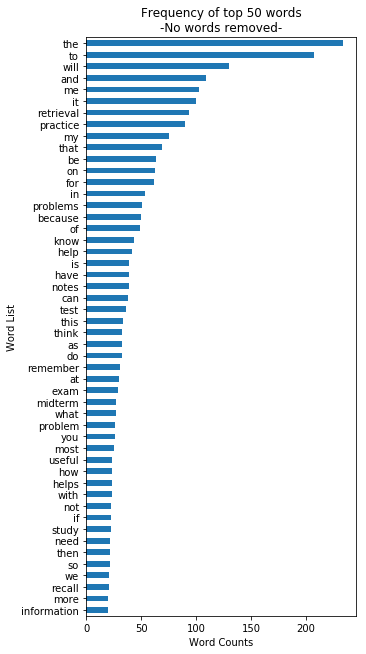

In [9]:
# visualization of frequency of top 50 words in the corpus
top_words_chart(responses, CountVectorizer(), 50, '-No words removed-')

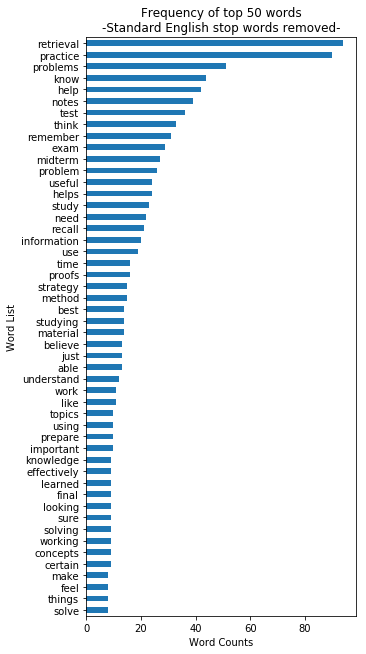

In [10]:
# visualization of frequency of top 50 words in the corpus AFTER removing standard English stop words (e.g., the)
top_words_chart(responses, CountVectorizer(stop_words='english'), 50, '-Standard English stop words removed-')

In [11]:
standard_english_stop_words = list(TfidfVectorizer(stop_words='english').get_stop_words())

corpus_specific_stop_words = ['retrieval', 'practice', 'useful', 'problems', 'know', 'helps', 'help', 'll']

custom_stop_words = standard_english_stop_words + corpus_specific_stop_words

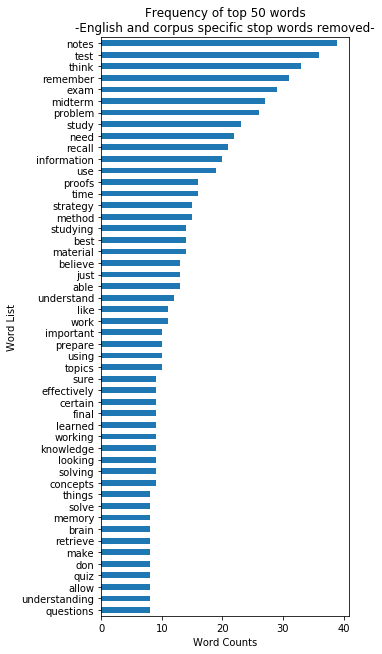

In [12]:
# visualization of frequency of top 50 words in the corpus AFTER removing standard English stop words (e.g., the) and corpus specific stop words (e.g., retrieval)
top_words_chart(responses, CountVectorizer(stop_words=custom_stop_words), 50, '-English and corpus specific stop words removed-')

# Define helper functions to print/summarize/visualize results of topic modeling

In [13]:
def get_top_words(model, feature_names, n_top_words):
    """Return a table of the top words in a topic
    
    Parameters
    ----------
    model : trained scikit-learn topic model
    
    feature_names : iterable
        Contains the vocabulary used in the training set for model.
        
    n : int
        The number of top words to return per topic.
        
    Returns
    -------
    top_words : pandas DataFrame
        Each column represents a topic.  Going down a column gives the top n most likely words for the associated topic.
    """
    top_words = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words['topic %d' % topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return top_words

In [14]:
def print_most_aligned_documents(topic_model, vectorized_corpus, corpus, topic, n=None):
    """Print only the documents that are aligned most with the chosen topic"""
    all_topic_alignment = topic_model.transform(vectorized_corpus)
    topic_alignment_filter = all_topic_alignment.argmax(axis=1) == topic
    our_topic_alignment = all_topic_alignment[:, topic]
    sorted_by_alignment = pd.Series(our_topic_alignment)[topic_alignment_filter].sort_values(ascending=False)
    for doc_idx in sorted_by_alignment.head(n=n).index:
        print(doc_idx)
        print(' | '.join(['%s: %s' % (i, v) for i, v in pd.Series(all_topic_alignment[doc_idx]).sort_values(ascending=False).items()]))
        print(corpus[doc_idx])
        print()

In [15]:
def topic_bar_chart(topic_model, vectorized_corpus):
    """A bar chart that displays distribution of topics as primary topics"""
    all_topic_alignments = topic_model.transform(vectorized_corpus)
    primary_topics = pd.Series(all_topic_alignments.argmax(axis=1))
    topic_counts = primary_topics.groupby(primary_topics).size()
    ax = topic_counts.plot(kind='bar', title='Distribution of Documents by Topic')
    ax.xaxis.set_label_text('Topics')
    ax.yaxis.set_label_text('Number of Documents')

In [16]:
def topic_word_clouds(model, vectorizer):
    """Display word clouds for the learned topics of model"""
    n_rows = math.ceil(len(model.components_)/2)
    fig_width = 10
    fig_height = 3*n_rows
    fig = plt.figure(figsize=(fig_width, fig_height))
    for i, c in enumerate(model.components_):
        wc = wordcloud.WordCloud(background_color='white').generate_from_frequencies({w: f for w, f in zip(vectorizer.get_feature_names(), c)})
        vertical_step = 1/n_rows
        ax_height = 0.8 * vertical_step
        ax = fig.add_axes([(i % 2)*0.5, 1 - vertical_step - (i // 2)*vertical_step, 0.45, ax_height])
        ax.imshow(wc, interpolation="bilinear")
        ax.axis('off')
        ax.set(title='topic %d' % i)

# Encode/vectorize the responses into a matrix by using TF-IDF (Term Frequency-Inverse Document Frequency)

### I accounted for English stop words and corpus specific stop words above, but I haven't done any stemming, etc. I'll refine a little more. 

##### Stemming & Lemmatization--
Source: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. 
EX: instance: am, are, is --> be
EX: car, cars, car's, cars' --> car 

The result of this mapping of text will be something like: the boy's cars are different colors --> the boy car be differ color 

However, the two words differ in their flavor. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma . If confronted with the token saw, stemming might return just s, whereas lemmatization would attempt to return either see or saw depending on whether the use of the token was as a verb or a noun. The two may also differ in that stemming most commonly collapses derivationally related words, whereas lemmatization commonly only collapses the different inflectional forms of a lemma. Linguistic processing for stemming or lemmatization is often done by an additional plug-in component to the indexing process, and a number of such components exist, both commercial and open-source...

##### Tokenization--
Source: https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. H
EX: Friends, Romans, Countrymen, lend me your ears; --> Friends Romans Countrymen lend me your ears

These tokens are often loosely referred to as terms or words, but it is sometimes important to make a type/token distinction. A token is an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing. A type is the class of all tokens containing the same character sequence. A term is a (perhaps normalized) type that is included in the IR system's dictionary. The set of index terms could be entirely distinct from the tokens, for instance, they could be semantic identifiers in a taxonomy, but in practice in modern IR systems they are strongly related to the tokens in the document.

The major question of the tokenization phase is what are the correct tokens to use? In this example, it looks fairly trivial: you chop on whitespace and throw away punctuation characters. This is a starting point, but even for English there are a number of tricky cases. For example, what do you do about the various uses of the apostrophe for possession and contractions?
Which one(s) should we use: O'Neill --> neill, o'neill, oneill, o' neill, o neill?

These issues of tokenization are language-specific. It thus requires the language of the document to be known. Language identification based on classifiers that use short character subsequences as features is highly effective; most languages have distinctive signature patterns... 

In English, hyphenation is used for various purposes ranging from splitting up vowels in words (co-education) to joining nouns as names (Hewlett-Packard) to a copyediting device to show word grouping (the hold-him-back-and-drag-him-away maneuver). It is easy to feel that the first example should be regarded as one token (and is indeed more commonly written as just coeducation), the last should be separated into words, and that the middle case is unclear. Handling hyphens automatically can thus be complex: it can either be done as a classification problem, or more commonly by some heuristic rules, such as allowing short hyphenated prefixes on words, but not longer hyphenated forms...

In [17]:
# initialize a PorterStemmer
p_stemmer = PorterStemmer()

In [18]:
# get default TfIdf preprocessor and tokenizer to use in custom preprocessing for vectorizing
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
default_tfidf_preprocessor = tfidf_vectorizer.build_preprocessor()
default_tfidf_tokenizer = tfidf_vectorizer.build_tokenizer()

In [19]:
# define representative words for stem classes
stemming_counts = {}
for response in responses:
    for word in default_tfidf_tokenizer(default_tfidf_preprocessor(response)):
        stem = p_stemmer.stem(word)
        if stem in stemming_counts:
            if word in stemming_counts[stem]:
                stemming_counts[stem][word] += 1
            else:
                stemming_counts[stem][word] = 1
        else:
            stemming_counts[stem] = {word: 1}

stem_map = {}
for stem, d in stemming_counts.items():
    stem_map[stem] = max(d, key=d.get)

In [20]:
# mapping midterm but not test because test is used to refer to self-testing, not the actual exam
def midterm_map(x):
    if x != 'midterm':
        return x
    else:
        return 'exam'

In [21]:
# Below applies the normal tokenizer from the TF-IDF Applies custom piece,
# the porter stemmer, to map words to their stem and then the actual word
# that is most representative of that stem in the corpus. Then I change any
# instance of "midterm" to "exam".
def custom_tokenizer(doc):
    default_tokens = default_tfidf_tokenizer(doc)
    stemmed_tokens = [stem_map[p_stemmer.stem(word)] for word in default_tokens]
    return [midterm_map(x) for x in stemmed_tokens]

In [22]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer_stopped_stemmed = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=None, tokenizer=custom_tokenizer,
                                   stop_words=standard_english_stop_words + corpus_specific_stop_words)
t0 = time()
tfidf_stopped_stemmed = tfidf_vectorizer_stopped_stemmed.fit_transform(responses)
print("done in %0.3fs." % (time() - t0))


Extracting tf-idf features for NMF...
done in 0.254s.


In [23]:
n_samples_stopped, n_features_stopped = tfidf_stopped_stemmed.shape

## Set the number of topics and the number of words per topic to print

In [24]:
# this is used to set number of topics in the topic model
# i first tried 15 then 10 topics, but those were excessive. so, i changed this to 6
n_components = 6
# for each topic (a list of words, in this case), this number says I'll print out the top 20 words that comprise each topic
n_top_words = 20

In [25]:
# fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples_stopped, n_features_stopped))
t0 = time()
nmf_stopped_stemmed = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_stopped_stemmed)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer_stopped_stemmed.get_feature_names()
get_top_words(nmf_stopped_stemmed, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=133 and n_features=177...
done in 0.255s.

Topics in NMF model (Frobenius norm):


,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5
0,study,remember,test,learned,exam,best
1,notes,solving,simulate,topics,prepare,believe
2,need,processes,understand,don,anxiety,method
3,think,steps,conditions,remind,final,effectively
4,recall,proofs,like,past,previous,memorize
5,allow,questions,prepare,information,think,way
6,information,good,material,final,just,work
7,looking,think,just,feel,mentality,successful
8,work,time,method,like,ensure,study
9,time,wasting,concepts,certain,work,kill


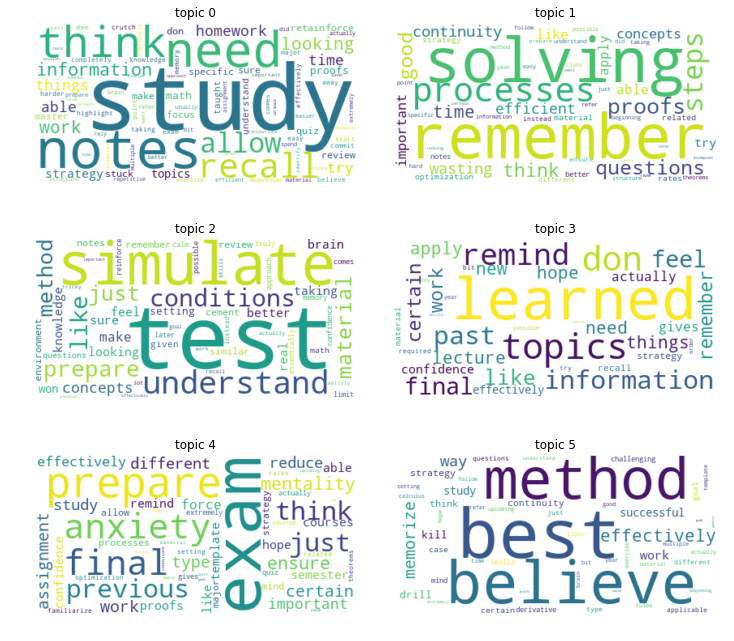

In [26]:
topic_word_clouds(nmf_stopped_stemmed, tfidf_vectorizer_stopped_stemmed)

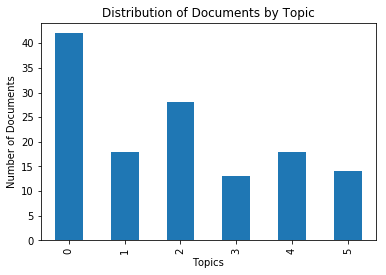

In [27]:
topic_bar_chart(nmf_stopped_stemmed, tfidf_stopped_stemmed)

In [28]:
# documents most aligned with topic 1
print_most_aligned_documents(nmf_stopped_stemmed, tfidf_stopped_stemmed, responses, 1, n=10)

132
1: 0.531594324094 | 5: 0.0 | 4: 0.0 | 3: 0.0 | 2: 0.0 | 0: 0.0
Because if I practice retrieval, I can remember how to solve problems

117
1: 0.448375286292 | 0: 0.0241961304089 | 4: 0.0010650848548 | 5: 0.0 | 3: 0.0 | 2: 0.0
I think retrieval practice will be helpful for remembering proofs and processes for solving problems.

5
1: 0.348215111048 | 2: 0.0198911036455 | 0: 0.0151478006129 | 5: 0.0 | 4: 0.0 | 3: 0.0
Retrieval practice will help me remember more information in a short amount of time. I will practice and continue to practice more and more problems so that I can remember how to do them, while understanding why we do what we do. The more I practice, the better I will get at solving problems efficiently.

76
1: 0.324444497784 | 0: 0.00865945890439 | 4: 0.00558134420485 | 5: 0.0 | 3: 0.0 | 2: 0.0
I think retrieval practice will be useful because it will help me remember the proofs, and the processes to solve related rates and optimization problems.

50
1: 0.277620647016 | 4

In [29]:
# documents most aligned with topic 2
print_most_aligned_documents(nmf_stopped_stemmed, tfidf_stopped_stemmed, responses, 2, n=10)

121
2: 0.343536508997 | 5: 0.0 | 4: 0.0 | 3: 0.0 | 1: 0.0 | 0: 0.0
It helps me get in the mindest of taking a test, as I won't have anything to look at on the test.

103
2: 0.340604260628 | 5: 0.0 | 4: 0.0 | 3: 0.0 | 1: 0.0 | 0: 0.0
It will help the most with understanding the material on the test.

68
2: 0.340287755792 | 5: 0.0 | 4: 0.0 | 3: 0.0 | 1: 0.0 | 0: 0.0
It helps me simulate test conditions.

16
2: 0.309691643966 | 4: 0.198878512728 | 5: 0.0450502830756 | 0: 0.0230105240372 | 3: 0.0 | 1: 0.0
Retrieval Practice will  be useful for midterm preparation because as I study I will be doing practice problems that will help me on the test. Retrieval practice will prepare me effectively just because is how it helps me on all of my tests.

41
2: 0.309251421644 | 5: 0.0 | 4: 0.0 | 3: 0.0 | 1: 0.0 | 0: 0.0
It helps simulate what it would be like in a real test situation.

106
2: 0.280566946384 | 1: 0.175667049773 | 5: 0.121561851114 | 4: 0.0 | 3: 0.0 | 0: 0.0
So that I can remember which

## Make Bokeh interactive plot

This still needs to be tweaked prior to presentation, but it is a great starting point.

Each document (student response) will be represented by a colored bubble in the plot. The bubble's color will represent what topic the document is most aligned with. The opacity of the bubble represents how well aligned the response is with the topic; the more opaque, the more aligned that document is with that topic. There are also tools that allow you to zoom and pan.

By default, the plot will contain all responses on all surveys. You can limit it to particular surveys and/or particular students. I used 3 surveys in my model, and I can select each of the three individually and check if I notice trends over time. 

You can hover over the dots to bring up information about a document. Specifically, hovering over a single bubble will show the index, survey ID, student ID, survey response, and topic number the response is most aligned with. 
For example, student 683's response on Survey 4A--"It helps me get in the mindest of taking a test, as I won't have anything to look at on the test"--is most aligned with topic 2 and the hover shows:
* student: 683
* survey: 4A
* primary_topic: 2
* response: It helps me get in the mindest of taking a test, as I won't have anything to look at on the test.

Caution: The hover doesn't work well for some long responses--the text runs off the left hand side of the page. This is a potential [workaround](https://groups.google.com/a/continuum.io/forum/#!topic/bokeh/tQGcRIICZC8), but I'm looking for something better.

In [30]:
X = nmf_stopped_stemmed.transform(tfidf_stopped_stemmed)

X_embedded = TSNE().fit_transform(X)

colormap = bokeh.palettes.Category10_10 #{0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue', 5: 'indigo', 6: 'violet', 7: 'pink'}

original_source = ColumnDataSource(data=dict(
    x=X_embedded[:, 0].tolist(),
    y=X_embedded[:, 1].tolist(),
    student=[str(s) for s in students],
    survey=surveys,
    response=responses,  #['\n'.join(textwrap.wrap(r, width=10)) for r in responses],
    primary_topic=X.argmax(axis=1).tolist(),
    color=[colormap[x] for x in X.argmax(axis=1)],
    primary_topic_alignment=(X.max(axis=1)/0.6).tolist()
))

source = ColumnDataSource(data=original_source.data)

hover = HoverTool(tooltips=[
    ("student", "@student"),
    ("survey", "@survey"),
    ("index", "$index"),
    ("primary_topic", "@primary_topic"),
    ("response", "@response"),
])

axis_range = (X_embedded.min() - 1, X_embedded.max() + 1)
p = figure(plot_width=600, plot_height=600, tools = "pan,wheel_zoom,box_zoom,reset",
           title="", x_range=axis_range, y_range=axis_range, toolbar_location='right')
p.add_tools(hover)
p.circle('x', 'y', size=20, source=source, color='color', alpha='primary_topic_alignment')

widget_width = 200

survey_select = MultiSelect(
        title="Survey", value=['all'], options=['all', '2A', '3A', '4A'], width=widget_width)

student_IDs = [str(s) for s in sorted(set(students))]
student_select = MultiSelect(title='Student ID', value=['all'],
                           options=['all'] + student_IDs, width=widget_width)

update_button = Button(label='Update Plot', width=widget_width)

combined_callback_code = """
var data = source.data;
var original_data = original_source.data;
var surveys = survey_select.value;
var students = student_select.value;
for (var key in original_data) {
    data[key] = [];
    for (var i = 0; i < original_data['response'].length; ++i) {
        if ((surveys.indexOf('all') >= 0 || surveys.indexOf(original_data['survey'][i]) >= 0) && (students.indexOf('all') >= 0 || students.indexOf(original_data['student'][i]) >= 0)) {
            data[key].push(original_data[key][i]);
        }
    }
}
source.change.emit()
"""

generic_callback = bokeh.models.CustomJS(
    args=dict(source=source,
              original_source=original_source,
              survey_select=survey_select,
              student_select=student_select),
    code=combined_callback_code)

#update_button.js_on_click(generic_callback)

update_button.callback = generic_callback

# on_click(generic_callback)

#layout = bokeh.layouts.row(bokeh.layouts.column(survey_select, student_select, update_button), p)
layout = bokeh.layouts.row([widgetbox(survey_select, student_select, update_button), p], sizing_mode='fixed')
show(layout)